In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
import os
import glob
from collections import deque

In [3]:
def detect_red_dots(frame):
    """
    프레임에서 빨간점들을 감지하고 위치를 반환하는 함수
    """
    # BGR을 HSV로 변환
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # 빨간색 범위 정의 (HSV)
    # 빨간색은 HSV에서 두 개의 범위로 나뉩니다
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    
    # 빨간색 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 컨투어 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 빨간점들의 중심 좌표 저장
    red_dots = []
    
    for contour in contours:
        # 작은 노이즈 제거 (최소 면적 필터)
        if cv2.contourArea(contour) > 50:  # 면적 임계값 조정 가능
            # 컨투어의 중심점 계산
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                red_dots.append((cx, cy))
    
    # 가장 큰 3개의 점만 반환 (면적 기준)
    if len(red_dots) > 3:
        areas = []
        for contour in contours:
            if cv2.contourArea(contour) > 50:
                areas.append(cv2.contourArea(contour))
        
        # 면적이 큰 순서대로 정렬
        sorted_indices = np.argsort(areas)[::-1]
        red_dots = [red_dots[i] for i in sorted_indices[:3]]
    
    return red_dots

In [4]:
def track_red_dots_in_video(video_path):
    """
    비디오 파일에서 빨간점들을 추적하는 메인 함수
    """
    # 비디오 파일이 존재하는지 확인
    if not os.path.exists(video_path):
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return
    
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return
    
    # 비디오 정보 가져오기
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"비디오 정보:")
    print(f"- FPS: {fps}")
    print(f"- 총 프레임 수: {total_frames}")
    print(f"- 추적 시작...\n")
    
    frame_count = 0
    all_positions = []  # 모든 프레임의 위치 정보 저장
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 빨간점 감지
        red_dots = detect_red_dots(frame)
        
        # 결과 출력
        print(f"프레임 {frame_count + 1}: ", end="")
        if len(red_dots) > 0:
            print(f"빨간점 {len(red_dots)}개 발견 - 위치: {red_dots}")
        else:
            print("빨간점을 찾지 못했습니다.")
        
        # 위치 정보 저장
        all_positions.append({
            'frame': frame_count + 1,
            'positions': red_dots.copy()
        })
        
        # 시각화 (선택적)
        display_frame = frame.copy()
        for i, (x, y) in enumerate(red_dots):
            cv2.circle(display_frame, (x, y), 10, (0, 255, 0), 2)  # 초록색 원으로 표시
            cv2.putText(display_frame, f'P{i+1}', (x-10, y-15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # 프레임 표시 (ESC 키로 종료)
        cv2.imshow('Red Dot Tracking', display_frame)
        if cv2.waitKey(1) & 0xFF == 27:  # ESC 키
            break
        
        frame_count += 1
    
    # 리소스 해제
    cap.release()
    cv2.destroyAllWindows()
    
    # 결과 요약
    print(f"\n=== 추적 완료 ===")
    print(f"총 처리된 프레임: {frame_count}")
    
    # 통계 정보
    frames_with_dots = sum(1 for pos in all_positions if len(pos['positions']) > 0)
    print(f"빨간점이 발견된 프레임: {frames_with_dots}/{frame_count}")
    
    return all_positions

In [5]:
def save_positions_to_file(positions, filename="red_dot_positions.txt"):
    """
    추적 결과를 파일로 저장하는 함수
    """
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("프레임별 빨간점 위치 정보\n")
        f.write("=" * 50 + "\n\n")
        
        for pos_data in positions:
            f.write(f"프레임 {pos_data['frame']}: ")
            if pos_data['positions']:
                f.write(f"빨간점 {len(pos_data['positions'])}개 - 위치: {pos_data['positions']}\n")
            else:
                f.write("빨간점 없음\n")
    
    print(f"결과가 {filename}에 저장되었습니다.")



In [6]:
video_file = "4.mp4"  # 실제 파일명으로 변경하세요

# 빨간점 추적 실행
positions = track_red_dots_in_video(video_file)

# 결과를 파일로 저장
if positions:
    save_positions_to_file(positions)

비디오 정보:
- FPS: 30.0
- 총 프레임 수: 426
- 추적 시작...

프레임 1: 빨간점 3개 발견 - 위치: [(173, 664), (648, 483), (358, 207)]
프레임 2: 빨간점 3개 발견 - 위치: [(174, 662), (650, 482), (360, 205)]
프레임 3: 빨간점 3개 발견 - 위치: [(177, 661), (651, 480), (361, 204)]
프레임 4: 빨간점 3개 발견 - 위치: [(179, 659), (653, 478), (363, 201)]
프레임 5: 빨간점 3개 발견 - 위치: [(181, 656), (655, 476), (364, 200)]
프레임 6: 빨간점 3개 발견 - 위치: [(182, 654), (656, 474), (365, 197)]
프레임 7: 빨간점 3개 발견 - 위치: [(181, 654), (657, 472), (365, 194)]
프레임 8: 빨간점 3개 발견 - 위치: [(179, 655), (658, 472), (364, 192)]
프레임 9: 빨간점 3개 발견 - 위치: [(178, 660), (658, 476), (363, 194)]
프레임 10: 빨간점 3개 발견 - 위치: [(177, 666), (658, 481), (363, 198)]
프레임 11: 빨간점 3개 발견 - 위치: [(174, 671), (652, 487), (359, 203)]
프레임 12: 빨간점 3개 발견 - 위치: [(169, 674), (644, 491), (354, 207)]
프레임 13: 빨간점 3개 발견 - 위치: [(163, 680), (638, 496), (349, 211)]
프레임 14: 빨간점 3개 발견 - 위치: [(156, 686), (632, 502), (343, 215)]
프레임 15: 빨간점 3개 발견 - 위치: [(152, 694), (627, 510), (339, 221)]
프레임 16: 빨간점 3개 발견 - 위치: [(152, 703), (619, 521)

In [7]:
def create_tracking_video(input_video_path, output_video_path="tracked_output.mp4"):
    """
    빨간점 추적 결과를 영상으로 생성하는 함수
    """
    # 비디오 파일 확인
    if not os.path.exists(input_video_path):
        print(f"비디오 파일을 찾을 수 없습니다: {input_video_path}")
        return
    
    # 입력 비디오 열기
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return
    
    # 비디오 정보 가져오기
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"입력 비디오 정보:")
    print(f"- 해상도: {width}x{height}")
    print(f"- FPS: {fps}")
    print(f"- 총 프레임 수: {total_frames}")
    
    # 출력 비디오 설정
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # 추적 데이터 저장
    track_history = [deque(maxlen=30) for _ in range(3)]  # 최대 30프레임 궤적
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # 초록, 파랑, 빨강
    point_labels = ['P1', 'P2', 'P3']
    
    frame_count = 0
    
    print("영상 처리 시작...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 빨간점 감지
        red_dots = detect_red_dots(frame)
        
        # 결과 프레임 생성
        result_frame = frame.copy()
        
        # 감지된 점들 처리
        for i, (x, y) in enumerate(red_dots):
            if i < 3:  # 최대 3개만 처리
                # 현재 위치를 궤적에 추가
                track_history[i].append((x, y))
                
                # 궤적 그리기
                if len(track_history[i]) > 1:
                    points = np.array(track_history[i], dtype=np.int32)
                    cv2.polylines(result_frame, [points], False, colors[i], 2)
                
                # 현재 위치 표시
                cv2.circle(result_frame, (x, y), 8, colors[i], -1)
                cv2.circle(result_frame, (x, y), 12, (255, 255, 255), 2)
                
                # 점 라벨 표시
                cv2.putText(result_frame, point_labels[i], (x-10, y-20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)
                
                # 좌표 표시
                cv2.putText(result_frame, f'({x}, {y})', (x-30, y+25), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, colors[i], 1)
        
        # 정보 패널 추가
        info_panel = np.zeros((100, width, 3), dtype=np.uint8)
        
        # 프레임 정보
        cv2.putText(info_panel, f'Frame: {frame_count + 1}/{total_frames}', 
                   (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # 감지된 점 개수
        cv2.putText(info_panel, f'Detected Points: {len(red_dots)}', 
                   (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # 현재 위치 정보
        for i, (x, y) in enumerate(red_dots[:3]):
            cv2.putText(info_panel, f'{point_labels[i]}: ({x}, {y})', 
                       (10, 75 + i*20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 1)
        
        # 프레임과 정보 패널 결합
        combined_frame = np.vstack([result_frame, info_panel])
        
        # 출력 비디오에 프레임 쓰기
        out.write(combined_frame)
        
        # 진행률 표시
        progress = (frame_count + 1) / total_frames * 100
        print(f"\r진행률: {progress:.1f}% ({frame_count + 1}/{total_frames})", end="")
        
        frame_count += 1
    
    # 리소스 해제
    cap.release()
    out.release()
    
    print(f"\n영상 생성 완료: {output_video_path}")
    print(f"총 처리된 프레임: {frame_count}")

def create_analysis_video(input_video_path, output_video_path="analysis_output.mp4"):
    """
    더 상세한 분석 정보를 포함한 영상 생성
    """
    if not os.path.exists(input_video_path):
        print(f"비디오 파일을 찾을 수 없습니다: {input_video_path}")
        return
    
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return
    
    # 비디오 정보
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 출력 비디오 설정 (더 큰 해상도로 정보 표시)
    output_width = width + 300  # 사이드 패널 추가
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, height))
    
    # 추적 데이터
    track_history = [deque(maxlen=50) for _ in range(3)]
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
    point_labels = ['Point 1', 'Point 2', 'Point 3']
    
    frame_count = 0
    distance_history = deque(maxlen=100)  # 점들 간의 거리 변화 추적
    
    print("상세 분석 영상 생성 시작...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 빨간점 감지
        red_dots = detect_red_dots(frame)
        
        # 메인 프레임 처리
        result_frame = frame.copy()
        
        # 감지된 점들과 궤적 그리기
        for i, (x, y) in enumerate(red_dots):
            if i < 3:
                track_history[i].append((x, y))
                
                # 궤적 그리기
                if len(track_history[i]) > 1:
                    points = np.array(track_history[i], dtype=np.int32)
                    cv2.polylines(result_frame, [points], False, colors[i], 2)
                
                # 현재 위치 표시
                cv2.circle(result_frame, (x, y), 8, colors[i], -1)
                cv2.circle(result_frame, (x, y), 12, (255, 255, 255), 2)
                cv2.putText(result_frame, f'P{i+1}', (x-8, y-15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 2)
        
        # 점들 간의 연결선 그리기
        if len(red_dots) >= 2:
            for i in range(len(red_dots)-1):
                if i < 2:  # 최대 3개 점
                    cv2.line(result_frame, red_dots[i], red_dots[i+1], (255, 255, 0), 1)
        
        # 사이드 패널 생성
        side_panel = np.zeros((height, 300, 3), dtype=np.uint8)
        
        # 정보 표시
        y_pos = 30
        cv2.putText(side_panel, "=== TRACKING INFO ===", (10, y_pos), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        y_pos += 30
        
        cv2.putText(side_panel, f"Frame: {frame_count + 1}/{total_frames}", 
                   (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        y_pos += 25
        
        cv2.putText(side_panel, f"Points Found: {len(red_dots)}", 
                   (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        y_pos += 35
        
        # 각 점의 정보 표시
        for i, (x, y) in enumerate(red_dots[:3]):
            cv2.putText(side_panel, f"{point_labels[i]}:", 
                       (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colors[i], 1)
            y_pos += 20
            cv2.putText(side_panel, f"  X: {x}, Y: {y}", 
                       (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (200, 200, 200), 1)
            y_pos += 25
        
        # 점들 간의 거리 계산 및 표시
        if len(red_dots) >= 2:
            y_pos += 10
            cv2.putText(side_panel, "=== DISTANCES ===", (10, y_pos), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            y_pos += 25
            
            for i in range(len(red_dots)-1):
                if i < 2:
                    x1, y1 = red_dots[i]
                    x2, y2 = red_dots[i+1]
                    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    cv2.putText(side_panel, f"P{i+1}-P{i+2}: {distance:.1f}px", 
                               (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (200, 200, 200), 1)
                    y_pos += 20
        
        # 프레임 결합
        combined_frame = np.hstack([result_frame, side_panel])
        
        # 출력 비디오에 쓰기
        out.write(combined_frame)
        
        # 진행률 표시
        progress = (frame_count + 1) / total_frames * 100
        print(f"\r진행률: {progress:.1f}% ({frame_count + 1}/{total_frames})", end="")
        
        frame_count += 1
    
    # 리소스 해제
    cap.release()
    out.release()
    
    print(f"\n상세 분석 영상 생성 완료: {output_video_path}")

def play_video(video_path):
    """
    생성된 영상 재생
    """
    if not os.path.exists(video_path):
        print(f"영상 파일을 찾을 수 없습니다: {video_path}")
        return
    
    cap = cv2.VideoCapture(video_path)
    
    print(f"영상 재생 중: {video_path}")
    print("ESC 키를 누르면 종료됩니다.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        cv2.imshow('Tracking Result', frame)
        
        # ESC 키로 종료
        if cv2.waitKey(30) & 0xFF == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [8]:
# 입력 비디오 파일 설정
input_video = "4.mp4"  # 실제 파일명으로 변경

print("=== 빨간점 추적 영상 생성 ===")
print("1. 기본 추적 영상 생성")
print("2. 상세 분석 영상 생성")
print("3. 영상 재생")

choice = input("\n선택하세요 (1-3): ")

if choice == '1':
    create_tracking_video(input_video, "basic_tracking.mp4")
    print("기본 추적 영상이 생성되었습니다: basic_tracking.mp4")
    
elif choice == '2':
    create_analysis_video(input_video, "detailed_analysis.mp4")
    print("상세 분석 영상이 생성되었습니다: detailed_analysis.mp4")
    
elif choice == '3':
    video_to_play = input("재생할 영상 파일명을 입력하세요: ")
    play_video(video_to_play)
    
else:
    print("기본 추적 영상을 생성합니다.")
    create_tracking_video(input_video, "basic_tracking.mp4")

=== 빨간점 추적 영상 생성 ===
1. 기본 추적 영상 생성
2. 상세 분석 영상 생성
3. 영상 재생
입력 비디오 정보:
- 해상도: 720x1280
- FPS: 30
- 총 프레임 수: 426
영상 처리 시작...
진행률: 99.8% (425/426)
영상 생성 완료: basic_tracking.mp4
총 처리된 프레임: 425
기본 추적 영상이 생성되었습니다: basic_tracking.mp4


In [9]:
K = np.array([
    [3010.740,    0.0,    2018.590],
    [   0.0,   3022.447,  1506.352],
    [   0.0,      0.0,       1.0   ]
])

### R 추측하기

In [ ]:
import cv2
import numpy as np
import os
from collections import deque
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 카메라 내부 매개변수
K = np.array([
    [3010.740,    0.0,    2018.590],
    [   0.0,   3022.447,  1506.352],
    [   0.0,      0.0,       1.0   ]
])

In [ ]:
def debug_points_detection(frame, red_dots):
    """
    점 감지 결과를 시각적으로 확인하는 함수
    """
    debug_frame = frame.copy()
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, (x, y) in enumerate(red_dots):
        color = colors[i % len(colors)]
        cv2.circle(debug_frame, (x, y), 10, color, -1)
        cv2.putText(debug_frame, f'P{i+1}({x},{y})', (x-30, y-15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    cv2.imshow('Debug Points', debug_frame)
    cv2.waitKey(1)
    
    return debug_frame

def estimate_relative_rotation_improved(points1, points2, debug=False):
    """
    개선된 상대적 회전 추정 함수
    """
    if len(points1) < 3 or len(points2) < 3:
        if debug:
            print(f"점이 부족합니다: {len(points1)}, {len(points2)}")
        return None
    
    points1 = np.array(points1, dtype=np.float32)
    points2 = np.array(points2, dtype=np.float32)
    
    if debug:
        print(f"Points1: {points1}")
        print(f"Points2: {points2}")
    
    # 방법 1: Essential Matrix 사용 (더 안정적)
    try:
        # 점들을 정규화된 좌표로 변환
        K_inv = np.linalg.inv(K)
        
        # 동차좌표로 변환
        points1_h = np.column_stack([points1, np.ones(len(points1))])
        points2_h = np.column_stack([points2, np.ones(len(points2))])
        
        # 정규화된 좌표
        points1_norm = (K_inv @ points1_h.T).T[:, :2]
        points2_norm = (K_inv @ points2_h.T).T[:, :2]
        
        if debug:
            print(f"Normalized points1: {points1_norm}")
            print(f"Normalized points2: {points2_norm}")
        
        # Essential Matrix 계산
        E, mask = cv2.findEssentialMat(points1_norm, points2_norm, 
                                      focal=1.0, pp=(0., 0.), 
                                      method=cv2.RANSAC, 
                                      prob=0.999, threshold=0.01)
        
        if E is not None and mask is not None:
            # 회전과 평행이동 복구
            _, R, t, mask2 = cv2.recoverPose(E, points1_norm, points2_norm)
            
            if debug:
                print(f"Essential matrix 방법 성공")
                print(f"Rotation matrix:\n{R}")
            
            return R
            
    except Exception as e:
        if debug:
            print(f"Essential matrix 방법 실패: {e}")
    
    # 방법 2: 호모그래피 사용 (백업)
    try:
        if len(points1) >= 4 and len(points2) >= 4:
            H, mask = cv2.findHomography(points1, points2, 
                                       cv2.RANSAC, 
                                       ransacReprojThreshold=5.0,
                                       maxIters=2000,
                                       confidence=0.995)
            
            if H is not None:
                if debug:
                    print(f"Homography matrix:\n{H}")
                
                # 호모그래피에서 회전 추출
                K_inv = np.linalg.inv(K)
                R_approx = K_inv @ H @ K
                
                # 회전 행렬로 정규화
                U, _, Vt = np.linalg.svd(R_approx[:3, :3])
                R = U @ Vt
                
                # 행렬식 확인
                if np.linalg.det(R) < 0:
                    Vt[-1, :] *= -1
                    R = U @ Vt
                
                if debug:
                    print(f"호모그래피 방법 성공")
                    print(f"Rotation matrix:\n{R}")
                
                return R
                
    except Exception as e:
        if debug:
            print(f"호모그래피 방법 실패: {e}")
    
    # 방법 3: 간단한 아핀 변환 (최후 수단)
    try:
        if len(points1) >= 3 and len(points2) >= 3:
            # 처음 3개 점만 사용
            M = cv2.getAffineTransform(points1[:3], points2[:3])
            
            if M is not None:
                # 아핀 변환에서 회전 부분 추출
                R_2d = M[:2, :2]
                
                # 2D 회전을 3D로 확장 (Z축 회전으로 가정)
                angle = np.arctan2(R_2d[1, 0], R_2d[0, 0])
                R = np.array([
                    [np.cos(angle), -np.sin(angle), 0],
                    [np.sin(angle),  np.cos(angle), 0],
                    [0,              0,             1]
                ])
                
                if debug:
                    print(f"아핀 변환 방법 성공")
                    print(f"Rotation matrix:\n{R}")
                
                return R
                
    except Exception as e:
        if debug:
            print(f"아핀 변환 방법 실패: {e}")
    
    if debug:
        print("모든 방법 실패")
    
    return None

def track_relative_rotation_debug(video_path):
    """
    디버그 정보를 포함한 상대적 회전 추적
    """
    if not os.path.exists(video_path):
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return None
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return None
    
    print("디버그 모드로 상대적 회전 추적 시작...")
    
    frame_count = 0
    rotation_data = []
    reference_points = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 빨간점 감지
        red_dots = detect_red_dots(frame)
        
        # 디버그 시각화
        debug_frame = debug_points_detection(frame, red_dots)
        
        print(f"\n--- 프레임 {frame_count} ---")
        print(f"감지된 점 개수: {len(red_dots)}")
        
        if len(red_dots) >= 3:
            print(f"감지된 점들: {red_dots[:3]}")
            
            if reference_points is None:
                # 첫 번째 프레임의 점들을 참조점으로 설정
                reference_points = red_dots[:3].copy()
                
                rotation_data.append({
                    'frame': frame_count,
                    'rotation_matrix': np.eye(3),
                    'roll': 0.0,
                    'pitch': 0.0,
                    'yaw': 0.0
                })
                
                print(f"기준 프레임 설정: {reference_points}")
            else:
                print(f"참조점들: {reference_points}")
                print(f"현재점들: {red_dots[:3]}")
                
                # 점들 간의 거리 변화 확인
                ref_dist = np.linalg.norm(np.array(reference_points[1]) - np.array(reference_points[0]))
                cur_dist = np.linalg.norm(np.array(red_dots[1]) - np.array(red_dots[0]))
                print(f"거리 변화: {ref_dist:.1f} -> {cur_dist:.1f} (비율: {cur_dist/ref_dist:.3f})")
                
                # 회전 추정 (디버그 모드)
                R = estimate_relative_rotation_improved(reference_points, red_dots[:3], debug=True)
                
                if R is not None:
                    # 오일러 각도 계산
                    roll, pitch, yaw = rotation_matrix_to_euler(R)
                    
                    rotation_data.append({
                        'frame': frame_count,
                        'rotation_matrix': R,
                        'roll': roll,
                        'pitch': pitch,
                        'yaw': yaw
                    })
                    
                    print(f"성공! Roll={roll:.2f}°, Pitch={pitch:.2f}°, Yaw={yaw:.2f}°")
                else:
                    print("회전 추정 실패!")
        else:
            print(f"점이 부족합니다: {len(red_dots)}개")
        
        frame_count += 1
        
        # 처음 몇 프레임만 자세히 확인
        if frame_count > 20:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    return rotation_data

def rotation_matrix_to_euler(R):
    """
    회전 행렬을 오일러 각도로 변환
    """
    sy = np.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
    
    singular = sy < 1e-6
    
    if not singular:
        x = np.arctan2(R[2,1], R[2,2])  # roll
        y = np.arctan2(-R[2,0], sy)     # pitch
        z = np.arctan2(R[1,0], R[0,0])  # yaw
    else:
        x = np.arctan2(-R[1,2], R[1,1])  # roll
        y = np.arctan2(-R[2,0], sy)      # pitch
        z = 0                            # yaw
    
    return np.degrees([x, y, z])

# detect_red_dots 함수도 개선해보겠습니다
def detect_red_dots_improved(frame, debug=False):
    """
    개선된 빨간점 감지 함수
    """
    # BGR을 HSV로 변환
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # 빨간색 범위를 더 넓게 설정
    lower_red1 = np.array([0, 30, 30])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([165, 30, 30])
    upper_red2 = np.array([180, 255, 255])
    
    # 빨간색 마스크 생성
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2
    
    if debug:
        cv2.imshow('Red Mask', mask)
        cv2.waitKey(1)
    
    # 노이즈 제거
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 컨투어 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 빨간점들의 중심 좌표와 면적 저장
    candidates = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 20:  # 최소 면적 감소
            # 컨투어의 중심점 계산
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                candidates.append((cx, cy, area))
    
    # 면적이 큰 순서대로 정렬
    candidates.sort(key=lambda x: x[2], reverse=True)
    
    # 상위 점들 반환 (최대 4개)
    red_dots = [(x, y) for x, y, area in candidates[:4]]
    
    if debug:
        print(f"감지된 후보들: {candidates}")
        print(f"최종 선택된 점들: {red_dots}")
    
    return red_dots

In [26]:
# 기존 detect_red_dots 함수를 개선된 버전으로 교체
detect_red_dots = detect_red_dots_improved

video_path = "4.mp4"  # 실제 비디오 파일 경로로 변경

# 디버그 모드로 실행
rotation_data = track_relative_rotation_debug(video_path)

디버그 모드로 상대적 회전 추적 시작...

--- 프레임 0 ---
감지된 점 개수: 3
감지된 점들: [(173, 664), (648, 483), (358, 208)]
기준 프레임 설정: [(173, 664), (648, 483), (358, 208)]

--- 프레임 1 ---
감지된 점 개수: 3
감지된 점들: [(174, 663), (649, 482), (359, 206)]
참조점들: [(173, 664), (648, 483), (358, 208)]
현재점들: [(174, 663), (649, 482), (359, 206)]
거리 변화: 508.3 -> 508.3 (비율: 1.000)
Points1: [[173. 664.]
 [648. 483.]
 [358. 208.]]
Points2: [[174. 663.]
 [649. 482.]
 [359. 206.]]
Normalized points1: [[-0.61300212 -0.27869868]
 [-0.4552336  -0.33858394]
 [-0.55155543 -0.42956982]]
Normalized points2: [[-0.61266997 -0.27902954]
 [-0.45490145 -0.33891479]
 [-0.55122329 -0.43023153]]
아핀 변환 방법 성공
Rotation matrix:
[[ 9.99999511e-01 -9.88449398e-04  0.00000000e+00]
 [ 9.88449398e-04  9.99999511e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
성공! Roll=0.00°, Pitch=-0.00°, Yaw=0.06°

--- 프레임 2 ---
감지된 점 개수: 3
감지된 점들: [(177, 661), (651, 480), (361, 205)]
참조점들: [(173, 664), (648, 483), (358, 208)]
현재점들: [(177, 661), (651,

In [27]:
def track_relative_rotation_complete(video_path):
    """
    전체 영상에 대한 상대적 회전 추적
    """
    if not os.path.exists(video_path):
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return None
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"전체 영상 회전 추적 시작... (총 {total_frames} 프레임)")
    
    frame_count = 0
    rotation_data = []
    reference_points = None
    successful_frames = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 빨간점 감지
        red_dots = detect_red_dots(frame)
        
        if len(red_dots) >= 3:
            if reference_points is None:
                # 첫 번째 프레임의 점들을 참조점으로 설정
                reference_points = red_dots[:3].copy()
                
                rotation_data.append({
                    'frame': frame_count,
                    'rotation_matrix': np.eye(3),
                    'roll': 0.0,
                    'pitch': 0.0,
                    'yaw': 0.0
                })
                
                successful_frames += 1
                print(f"프레임 {frame_count}: 기준 프레임 설정")
            else:
                # 회전 추정
                R = estimate_relative_rotation_improved(reference_points, red_dots[:3], debug=False)
                
                if R is not None:
                    # 오일러 각도 계산
                    roll, pitch, yaw = rotation_matrix_to_euler(R)
                    
                    rotation_data.append({
                        'frame': frame_count,
                        'rotation_matrix': R,
                        'roll': roll,
                        'pitch': pitch,
                        'yaw': yaw
                    })
                    
                    successful_frames += 1
                    
                    # 진행률 표시 (매 50프레임마다)
                    if frame_count % 50 == 0:
                        print(f"프레임 {frame_count}: Roll={roll:.2f}°, Pitch={pitch:.2f}°, Yaw={yaw:.2f}° "
                              f"(성공률: {successful_frames}/{frame_count+1})")
        
        frame_count += 1
    
    cap.release()
    
    print(f"\n=== 추적 완료 ===")
    print(f"총 프레임: {frame_count}")
    print(f"성공 프레임: {successful_frames}")
    print(f"성공률: {successful_frames/frame_count*100:.1f}%")
    
    return rotation_data

def create_detailed_visualization(rotation_data, save_path="detailed_rotation_analysis.png"):
    """
    상세한 회전 분석 시각화
    """
    if not rotation_data:
        print("시각화할 데이터가 없습니다.")
        return
    
    frames = [data['frame'] for data in rotation_data]
    rolls = [data['roll'] for data in rotation_data]
    pitches = [data['pitch'] for data in rotation_data]
    yaws = [data['yaw'] for data in rotation_data]
    
    # 4개 서브플롯 생성
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Roll 그래프
    ax1.plot(frames, rolls, 'r-', linewidth=2, label='Roll', alpha=0.8)
    ax1.fill_between(frames, rolls, alpha=0.3, color='red')
    ax1.set_ylabel('Roll (degrees)')
    ax1.set_title('Roll Rotation')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Pitch 그래프
    ax2.plot(frames, pitches, 'g-', linewidth=2, label='Pitch', alpha=0.8)
    ax2.fill_between(frames, pitches, alpha=0.3, color='green')
    ax2.set_ylabel('Pitch (degrees)')
    ax2.set_title('Pitch Rotation')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Yaw 그래프
    ax3.plot(frames, yaws, 'b-', linewidth=2, label='Yaw', alpha=0.8)
    ax3.fill_between(frames, yaws, alpha=0.3, color='blue')
    ax3.set_ylabel('Yaw (degrees)')
    ax3.set_xlabel('Frame')
    ax3.set_title('Yaw Rotation')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 전체 회전 크기 (벡터 크기)
    total_rotation = [np.sqrt(r**2 + p**2 + y**2) for r, p, y in zip(rolls, pitches, yaws)]
    ax4.plot(frames, total_rotation, 'm-', linewidth=2, label='Total Rotation', alpha=0.8)
    ax4.fill_between(frames, total_rotation, alpha=0.3, color='magenta')
    ax4.set_ylabel('Total Rotation (degrees)')
    ax4.set_xlabel('Frame')
    ax4.set_title('Total Rotation Magnitude')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 통계 출력
    print(f"\n=== 회전 통계 ===")
    print(f"Roll: 평균={np.mean(rolls):.2f}°, 범위=[{min(rolls):.2f}°, {max(rolls):.2f}°], 표준편차={np.std(rolls):.2f}°")
    print(f"Pitch: 평균={np.mean(pitches):.2f}°, 범위=[{min(pitches):.2f}°, {max(pitches):.2f}°], 표준편차={np.std(pitches):.2f}°")
    print(f"Yaw: 평균={np.mean(yaws):.2f}°, 범위=[{min(yaws):.2f}°, {max(yaws):.2f}°], 표준편차={np.std(yaws):.2f}°")
    print(f"최대 총 회전: {max(total_rotation):.2f}°")

def main_complete_tracking(video_path):
    """
    완전한 회전 추적 실행
    """
    print("=== 완전한 카메라 회전 추적 ===")
    
    # 전체 영상 추적
    rotation_data = track_relative_rotation_complete(video_path)
    
    if not rotation_data:
        print("회전 데이터를 추출할 수 없습니다.")
        return None
    
    # 상세 시각화
    create_detailed_visualization(rotation_data)
    
    # 결과 저장
    import json
    with open('rotation_data.json', 'w') as f:
        # numpy 배열을 리스트로 변환하여 저장
        save_data = []
        for data in rotation_data:
            save_data.append({
                'frame': data['frame'],
                'rotation_matrix': data['rotation_matrix'].tolist(),
                'roll': data['roll'],
                'pitch': data['pitch'],
                'yaw': data['yaw']
            })
        json.dump(save_data, f, indent=2)
    
    print("회전 데이터가 'rotation_data.json'에 저장되었습니다.")
    
    return rotation_data

=== 완전한 카메라 회전 추적 ===
전체 영상 회전 추적 시작... (총 426 프레임)
프레임 0: 기준 프레임 설정
프레임 50: Roll=0.00°, Pitch=-0.00°, Yaw=2.84° (성공률: 51/51)
프레임 100: Roll=0.00°, Pitch=-0.00°, Yaw=-94.12° (성공률: 101/101)
프레임 150: Roll=0.00°, Pitch=-0.00°, Yaw=-92.69° (성공률: 151/151)
프레임 200: Roll=0.00°, Pitch=-0.00°, Yaw=25.49° (성공률: 201/201)
프레임 250: Roll=0.00°, Pitch=-0.00°, Yaw=134.71° (성공률: 251/251)
프레임 300: Roll=0.00°, Pitch=-0.00°, Yaw=0.28° (성공률: 301/301)
프레임 350: Roll=0.00°, Pitch=-0.00°, Yaw=0.38° (성공률: 351/351)
프레임 400: Roll=0.00°, Pitch=-0.00°, Yaw=1.92° (성공률: 401/401)

=== 추적 완료 ===
총 프레임: 425
성공 프레임: 425
성공률: 100.0%


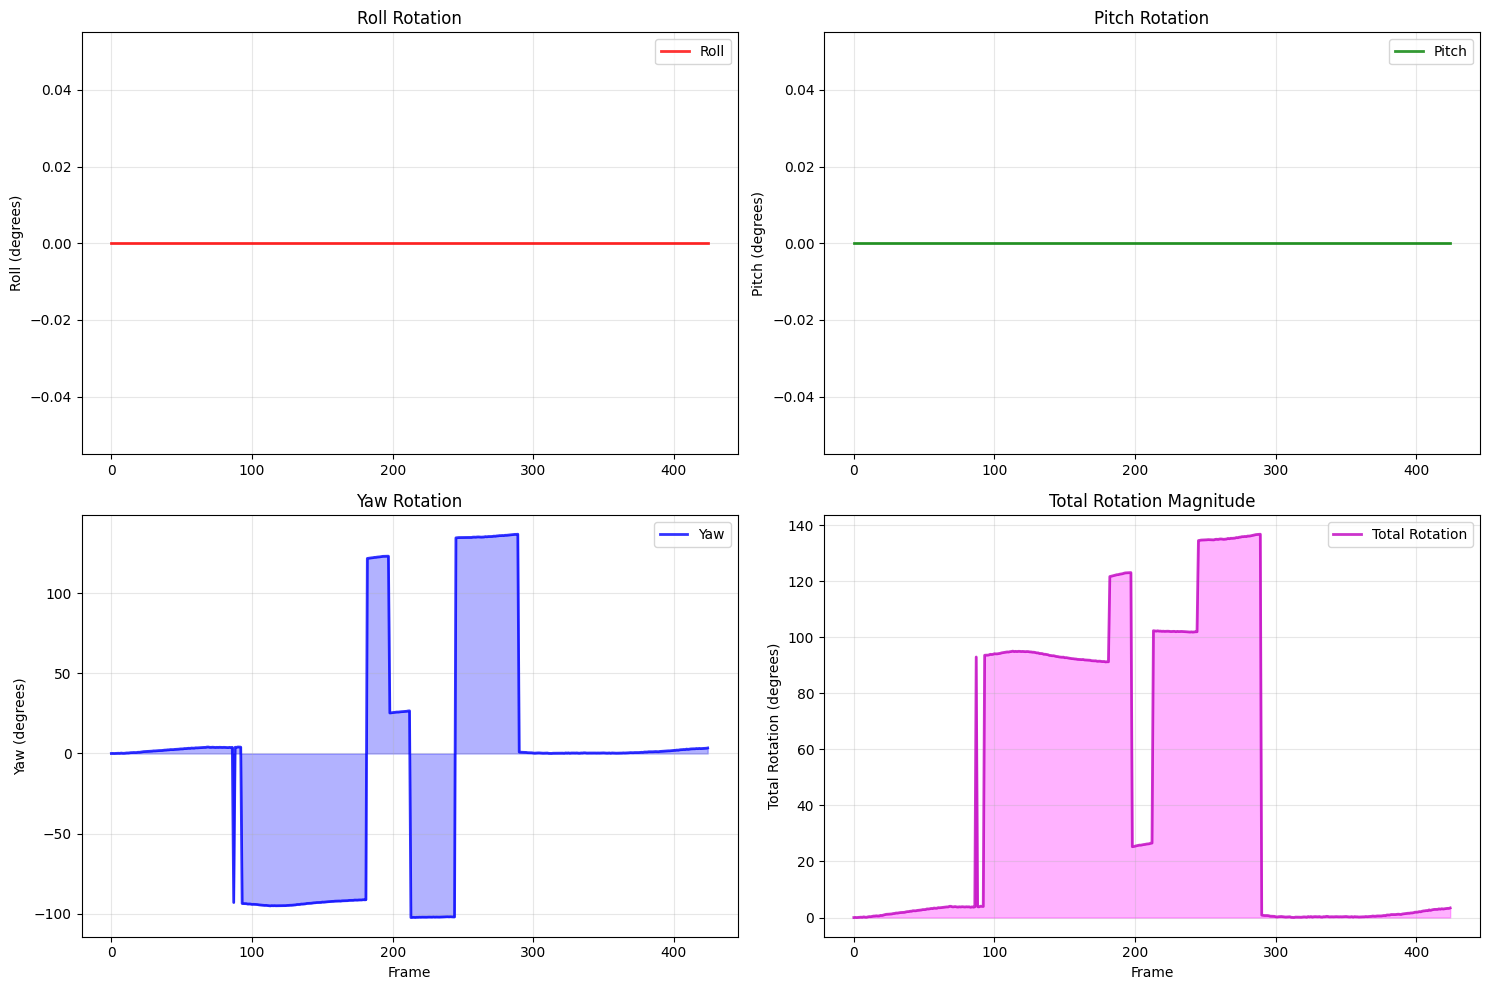


=== 회전 통계 ===
Roll: 평균=0.00°, 범위=[0.00°, 0.00°], 표준편차=0.00°
Pitch: 평균=0.00°, 범위=[0.00°, 0.00°], 표준편차=0.00°
Yaw: 평균=-6.79°, 범위=[-102.33°, 136.76°], 표준편차=71.53°
최대 총 회전: 136.76°
회전 데이터가 'rotation_data.json'에 저장되었습니다.


In [28]:

video_path = "4.mp4"  # 실제 비디오 파일 경로로 변경
rotation_data = main_complete_tracking(video_path)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def analyze_point_geometry(points):
    """
    점들의 기하학적 배치 분석
    """
    if len(points) < 3:
        return None
    
    p1, p2, p3 = points[:3]
    
    # 벡터 계산
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    
    # 각도 계산 (점들이 일직선상인지 확인)
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))
    
    # 삼각형 면적
    area = 0.5 * abs(np.cross(v1, v2))
    
    return {
        'angle_between_vectors': angle,
        'triangle_area': area,
        'is_nearly_collinear': angle < 10 or angle > 170  # 거의 일직선인지
    }

def estimate_rotation_pnp_method(points1, points2, K):
    """
    PnP를 사용한 3D 회전 추정 (더 정확한 방법)
    """
    if len(points1) < 3 or len(points2) < 3:
        return None
    
    # 첫 번째 프레임을 Z=0 평면에 배치
    points_3d = []
    for i, (x, y) in enumerate(points1):
        # 카메라 좌표계에서 역투영하여 Z=0 평면의 3D 점 생성
        # 임의의 깊이(예: 1000mm)로 설정
        depth = 1000.0
        x_3d = (x - K[0,2]) * depth / K[0,0]
        y_3d = (y - K[1,2]) * depth / K[1,1]
        points_3d.append([x_3d, y_3d, depth])
    
    points_3d = np.array(points_3d, dtype=np.float32)
    points_2d = np.array(points2, dtype=np.float32)
    
    # PnP로 외부 매개변수 추정
    success, rvec, tvec = cv2.solvePnP(points_3d, points_2d, K, None)
    
    if success:
        R_mat, _ = cv2.Rodrigues(rvec)
        return R_mat
    
    return None

def estimate_rotation_fundamental_matrix(points1, points2, K):
    """
    Fundamental Matrix를 사용한 회전 추정
    """
    if len(points1) < 8:  # Fundamental matrix는 최소 8개 점 필요
        return None
    
    points1 = np.array(points1, dtype=np.float32)
    points2 = np.array(points2, dtype=np.float32)
    
    # Fundamental Matrix 계산
    F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC)
    
    if F is not None:
        # Essential Matrix 계산: E = K^T * F * K
        E = K.T @ F @ K
        
        # 정규화된 좌표로 변환
        K_inv = np.linalg.inv(K)
        points1_h = np.column_stack([points1, np.ones(len(points1))])
        points2_h = np.column_stack([points2, np.ones(len(points2))])
        
        points1_norm = (K_inv @ points1_h.T).T[:, :2]
        points2_norm = (K_inv @ points2_h.T).T[:, :2]
        
        # 회전과 평행이동 복구
        _, R, t, mask2 = cv2.recoverPose(E, points1_norm, points2_norm)
        
        return R
    
    return None

def estimate_rotation_optical_flow(frame1, frame2, points1):
    """
    Optical Flow를 사용한 회전 추정
    """
    # 그레이스케일 변환
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # Lucas-Kanade optical flow
    points1 = np.array(points1, dtype=np.float32).reshape(-1, 1, 2)
    
    # optical flow 계산
    points2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, points1, None)
    
    # 성공적으로 추적된 점들만 선택
    good_points1 = points1[status.flatten() == 1]
    good_points2 = points2[status.flatten() == 1]
    
    if len(good_points1) >= 3:
        # Essential matrix 방법 사용
        points1_norm = cv2.undistortPoints(good_points1, K, None)
        points2_norm = cv2.undistortPoints(good_points2, K, None)
        
        E, mask = cv2.findEssentialMat(points1_norm, points2_norm, 
                                      focal=1.0, pp=(0., 0.), 
                                      method=cv2.RANSAC)
        
        if E is not None:
            _, R, t, mask2 = cv2.recoverPose(E, points1_norm, points2_norm)
            return R, good_points2.reshape(-1, 2)
    
    return None, None

def track_rotation_multiple_methods(video_path):
    """
    여러 방법을 사용하여 회전 추적
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다.")
        return None
    
    print("다중 방법으로 회전 추적 시작...")
    
    frame_count = 0
    rotation_data = []
    reference_points = None
    reference_frame = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        red_dots = detect_red_dots(frame)
        
        if len(red_dots) >= 3:
            if reference_points is None:
                reference_points = red_dots[:3].copy()
                reference_frame = frame.copy()
                
                # 점 배치 분석
                geometry = analyze_point_geometry(reference_points)
                print(f"점 배치 분석: {geometry}")
                
                rotation_data.append({
                    'frame': frame_count,
                    'method': 'reference',
                    'rotation_matrix': np.eye(3),
                    'roll': 0.0, 'pitch': 0.0, 'yaw': 0.0
                })
            else:
                results = {}
                
                # 방법 1: 개선된 호모그래피
                R1 = estimate_relative_rotation_improved(reference_points, red_dots[:3])
                if R1 is not None:
                    roll1, pitch1, yaw1 = rotation_matrix_to_euler(R1)
                    results['homography'] = {'R': R1, 'roll': roll1, 'pitch': pitch1, 'yaw': yaw1}
                
                # 방법 2: PnP
                R2 = estimate_rotation_pnp_method(reference_points, red_dots[:3], K)
                if R2 is not None:
                    roll2, pitch2, yaw2 = rotation_matrix_to_euler(R2)
                    results['pnp'] = {'R': R2, 'roll': roll2, 'pitch': pitch2, 'yaw': yaw2}
                
                # 방법 3: Optical Flow (더 많은 점 사용 가능)
                R3, tracked_points = estimate_rotation_optical_flow(reference_frame, frame, reference_points)
                if R3 is not None:
                    roll3, pitch3, yaw3 = rotation_matrix_to_euler(R3)
                    results['optical_flow'] = {'R': R3, 'roll': roll3, 'pitch': pitch3, 'yaw': yaw3}
                
                # 결과 저장
                rotation_data.append({
                    'frame': frame_count,
                    'results': results,
                    'points': red_dots[:3]
                })
                
                # 결과 출력 (매 50프레임마다)
                if frame_count % 50 == 0:
                    print(f"\n--- 프레임 {frame_count} ---")
                    for method, data in results.items():
                        print(f"{method}: Roll={data['roll']:.2f}°, Pitch={data['pitch']:.2f}°, Yaw={data['yaw']:.2f}°")
        
        frame_count += 1
        
        if frame_count > 100:  # 처음 100프레임만 테스트
            break
    
    cap.release()
    return rotation_data

def visualize_multiple_methods(rotation_data):
    """
    여러 방법의 결과를 비교 시각화
    """
    methods = ['homography', 'pnp', 'optical_flow']
    colors = ['blue', 'red', 'green']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    for method, color in zip(methods, colors):
        frames = []
        rolls = []
        pitches = []
        yaws = []
        
        for data in rotation_data:
            if 'results' in data and method in data['results']:
                frames.append(data['frame'])
                result = data['results'][method]
                rolls.append(result['roll'])
                pitches.append(result['pitch'])
                yaws.append(result['yaw'])
        
        if frames:
            axes[0].plot(frames, rolls, color=color, label=f'{method}', linewidth=2, alpha=0.7)
            axes[1].plot(frames, pitches, color=color, label=f'{method}', linewidth=2, alpha=0.7)
            axes[2].plot(frames, yaws, color=color, label=f'{method}', linewidth=2, alpha=0.7)
    
    axes[0].set_title('Roll Comparison')
    axes[0].set_ylabel('Roll (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Pitch Comparison')
    axes[1].set_ylabel('Pitch (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_title('Yaw Comparison')
    axes[2].set_ylabel('Yaw (degrees)')
    axes[2].set_xlabel('Frame')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
video_path = "4.mp4"

# 다중 방법으로 테스트
rotation_data = track_rotation_multiple_methods(video_path)

if rotation_data:
    # 결과 비교 시각화
    visualize_multiple_methods(rotation_data)